# Atmospheric composition distribution by CAMS and IASI

### Main goal:
* Compare IASI and CAMS datasets for CO and O<sub>3</sub> (Level 3).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime # Important for IASI and GOME-2

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
component_nom = 'O3'
sensor = 'iasi'
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define latitudes and longitudes
lat_min = 30
lat_max = 70
lon_min = -25
lon_max = 45

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
print('SEARCH PERIOD')
dates_unsorted = ('2020-01', '2020-02', '2020-04', '2020-10', '2020-12', '2021-07', '2021-03')
dates = tuple(sorted(dates_unsorted))
start_date = dates[0]
end_date = dates[-1]
print(f'- In months: {dates}')

SEARCH PERIOD
- In months: ('2020-01', '2020-02', '2020-04', '2020-10', '2020-12', '2021-03', '2021-07')


## 2. Model data

### Download, read and subset data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds = subset(model_ds, bbox)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 5)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -24.75 -24.0 -23.25 ... 43.5 44.25 45.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-10T07:27 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [7]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Collect and read data as xarray

In [8]:
sensor_product_names = []

for date in dates:

    sensor_product_name = IASI_download(component_nom, date)
    sensor_product_names.append(sensor_product_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  7167k      0 --:--:-- --:--:-- --:--:-- 7167k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  6149k      0 --:--:-- --:--:-- --:--:-- 6149k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  7217k      0 --:--:-- --:--:-- --:--:-- 7217k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1039k  100 1039k    0     0  6662k      0 --:--:-- --:--:-- --:--:-- 6662k
  % Total    % Received % Xferd  Average Speed   Tim

In [9]:
sensor_ds, sensor_type = IASI_read(sensor_product_names, component_nom)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 5)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    O3gridDAY       (time, latitude, longitude) float32 0.1429 0.151 ... nan nan
    O3gridNIGHT     (time, latitude, longitude) float32 nan nan ... 0.141 0.1467
    ErrorgridDAY    (time, latitude, longitude) float32 0.003853 ... nan
    ErrorgridNIGHT  (time, latitude, longitude) float32 nan nan ... 0.002762
Attributes: (12/34)
    title:                                   IASI/Metop-C ULB-LATMOS ozone (O...
    institution:                             AERIS
    product_version:                         6.5.1
    history:                                 2020-11-20 00:08:19 - Product ge...
    summary:                                 This dataset contains Level 3 oz...
    source:                                  EUMETSAT IASI Level 2 ozone (O3)...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_name:                            AERIS
    creator_type:                            institution
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [10]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.
The sensor component units have been converted from molec cm-2 to DU.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 5)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    O3gridDAY       (time, latitude, longitude) float64 320.0 338.0 ... nan nan
    O3gridNIGHT     (time, latitude, longitude) float64 nan nan ... 315.6 328.5
    ErrorgridDAY    (time, latitude, longitude) float64 8.625 5.184 ... nan nan
    ErrorgridNIGHT  (time, latitude, longitude) float64 nan nan ... 6.602 6.184
Attributes: (12/34)
    title:                                   IASI/Metop-C ULB-LATMOS ozone (O...
    institution:                             AERIS
    product_version:                         6.5.1
    history:                                 2020-11-20 00:08:19 - Product ge...
    summary:                                 This dataset contains Level 3 oz...
    source:                                  EUMETSAT IASI Level 2 ozone (O3)...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_name:                            AERIS
    creator_type:                            institution
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

## 4. Match data (and apply averaging kernels)

In [11]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR MONTH: 2020-01
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2020-02
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2020-04
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2020-10
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2020-12
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the senso

,latitude,longitude,time,O3gridDAY,O3gridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column
0,29.5,-25.5,2020-01-01,299.284804,290.400144,0.452052,0.463988,302.583099
1,29.5,-24.5,2020-01-01,297.109367,290.490260,0.437754,0.425563,302.583099
2,29.5,-23.5,2020-01-01,296.316537,292.643739,0.455010,0.559435,302.877930
3,29.5,-22.5,2020-01-01,292.732038,292.066260,0.403175,0.442537,303.155457
4,29.5,-21.5,2020-01-01,299.042375,292.812847,0.550015,0.475995,303.387970
...,...,...,...,...,...,...,...,...
2906,69.5,40.5,2020-12-01,NaN,277.741935,NaN,0.742601,290.479065
2907,69.5,41.5,2020-12-01,NaN,289.821093,NaN,1.416597,291.035400
2908,69.5,42.5,2020-12-01,NaN,276.120999,NaN,0.693131,292.189087
2909,69.5,43.5,2020-12-01,NaN,279.645051,NaN,0.713311,292.763824


## 5. Merge data and calculate difference

In [12]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

O3gridDAY  O3gridNIGHT  ErrorgridDAY  \
latitude longitude time                                                
29.5     -25.5     2020-01-01  299.284804   290.400144      0.452052   
                   2020-02-01  284.994557   289.166129      0.580096   
                   2020-04-01  318.989479   312.435117      0.527591   
                   2020-10-01  283.547316   277.112807      0.488880   
                   2020-12-01  281.212365   279.106948      0.446309   
...                                   ...          ...           ...   
69.5      44.5     2020-01-01  262.838026   287.308236      2.437309   
                   2020-02-01  309.013656   306.368118      1.074527   
                   2020-04-01  289.755484   288.092381      0.464332   
                   2020-10-01  286.470448   292.196416      0.774474   
                   2020-12-01         NaN   274.785123           NaN   

                               ErrorgridNIGHT  model_column  difference  
latitude longitude time                                                  
29.5     -25.5     2020-01-01        0.463988    302.583099   -3.298296  
                   2020-02-01        0.517245    298.177032  -13.182475  
                   2020-04-01        0.451764    328.796265   -9.806786  
                   2020-10-01        0.452425    290.274963   -6.727647  
                   2020-12-01        0.418225    289.442261   -8.229895  
...                                       ...           ...         ...  
69.5      44.5     2020-01-01        1.239178    315.442291  -52.604265  
                   2020-02-01        0.916566    320.219330  -11.205674  
                   2020-04-01        1.179977    315.053619  -25.298136  
                   2020-10-01        0.847075    288.290009   -1.819561  
                   2020-12-01        0.644256    293.333008         NaN  

[14555 rows x 6 columns]

## 6. Show comparison plots

### Select plot dates

In [13]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2020-01' '2020-02' '2020-04' '2020-10' '2020-12']


### Select plot extent

In [14]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-25, 30), (45, 70))


### Compare CAMS and IASI total columns

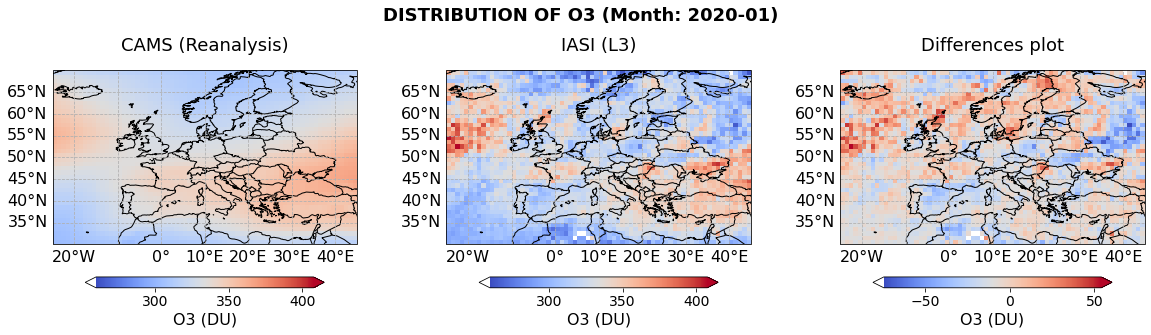

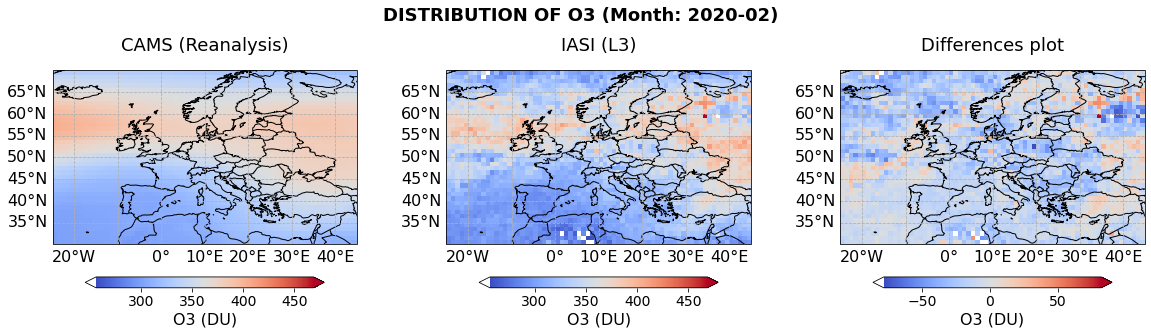

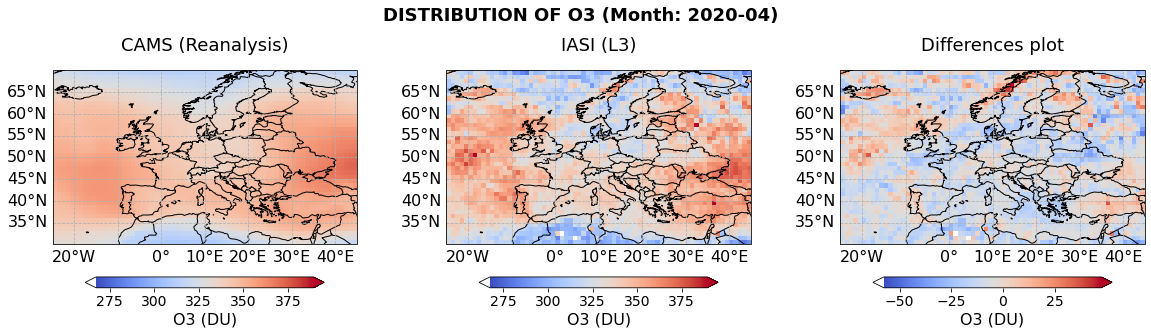

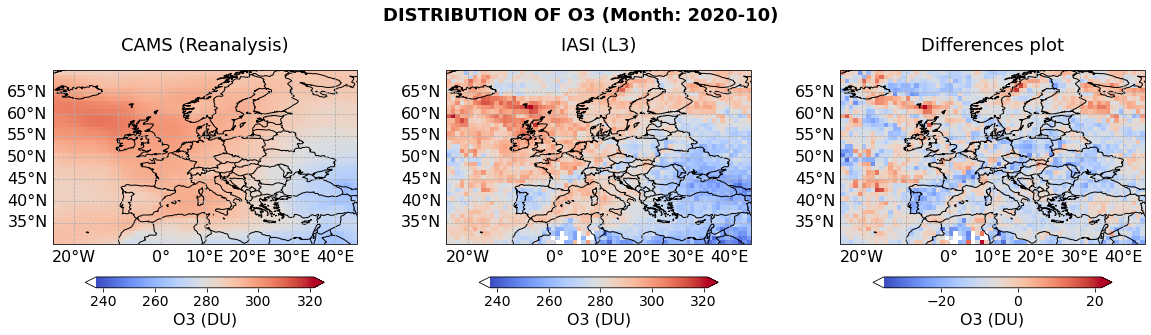

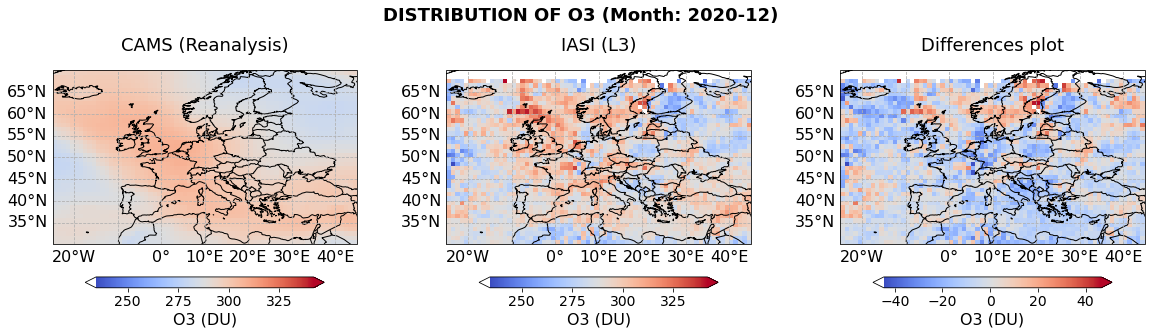

In [15]:
range_type = 'Equal' # Original, Positive, Equal
visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, 
                          plot_bbox, 20, 1.10, model_type, sensor_type, range_type)

## 7. Scatter plots

Month: 2020-01
Fit equation: O3_model = O3_sensor * 0.46 + (1.83E+02)
Coefficient of determination (R2): 0.45


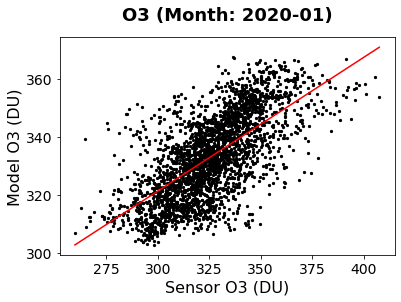

Month: 2020-02
Fit equation: O3_model = O3_sensor * 0.80 + (7.95E+01)
Coefficient of determination (R2): 0.75


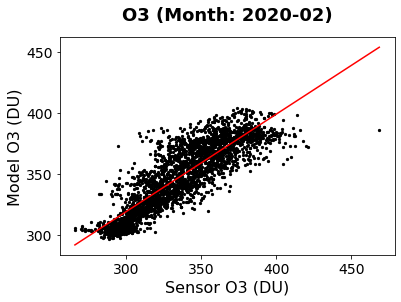

Month: 2020-04
Fit equation: O3_model = O3_sensor * 0.58 + (1.47E+02)
Coefficient of determination (R2): 0.58


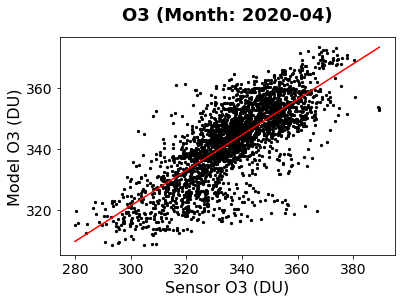

Month: 2020-10
Fit equation: O3_model = O3_sensor * 0.64 + (1.10E+02)
Coefficient of determination (R2): 0.70


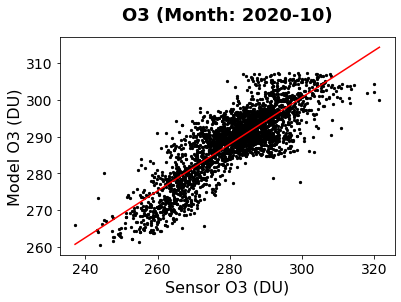

Month: 2020-12
Fit equation: O3_model = O3_sensor * 0.26 + (2.19E+02)
Coefficient of determination (R2): 0.17


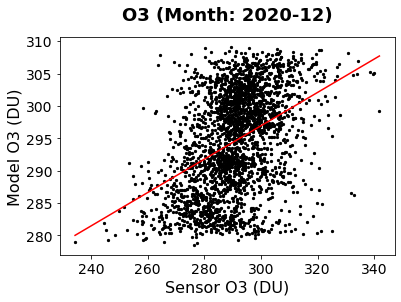

In [16]:
scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, plot_dates, plot_bbox, 1.05)

## 8. Retrieve nearest values to specific latitude and longitude

O3gridDAY  O3gridNIGHT  \
lat_search lon_search latitude longitude time                                  
50         60         49.5     44.5      2020-01-01  370.051515   344.152632   
                                         2020-02-01  399.205631   382.037278   
                                         2020-04-01  363.897590   368.262534   
                                         2020-10-01  270.278835   261.531443   
                                         2020-12-01  286.395222   286.846334   
4          10         29.5     9.5       2020-01-01  290.012581   306.233465   
                                         2020-02-01  296.717794   275.890623   
                                         2020-04-01  290.752587   280.619399   
                                         2020-10-01  259.054837   255.483810   
                                         2020-12-01  280.303250   266.299261   
20         30         29.5     29.5      2020-01-01  305.104898   279.425201   
                                         2020-02-01  307.840995   283.148652   
                                         2020-04-01  300.052773          NaN   
                                         2020-10-01  253.680780   244.688345   
                                         2020-12-01  284.661591   257.105344   

                                                     ErrorgridDAY  \
lat_search lon_search latitude longitude time                       
50         60         49.5     44.5      2020-01-01      1.093379   
                                         2020-02-01      1.051227   
                                         2020-04-01      0.379113   
                                         2020-10-01      0.365567   
                                         2020-12-01      1.118794   
4          10         29.5     9.5       2020-01-01      0.837963   
                                         2020-02-01      0.626885   
                                         2020-04-01      0.437628   
                                         2020-10-01      0.579214   
                                         2020-12-01      0.604691   
20         30         29.5     29.5      2020-01-01      1.647130   
                                         2020-02-01      1.291901   
                                         2020-04-01      1.295340   
                                         2020-10-01      1.545175   
                                         2020-12-01      1.384353   

                                                     ErrorgridNIGHT  \
lat_search lon_search latitude longitude time                         
50         60         49.5     44.5      2020-01-01        1.275565   
                                         2020-02-01        1.571479   
                                         2020-04-01        0.673935   
                                         2020-10-01        1.056298   
                                         2020-12-01        1.184872   
4          10         29.5     9.5       2020-01-01        1.310764   
                                         2020-02-01        1.246427   
                                         2020-04-01        0.884435   
                                         2020-10-01        0.710684   
                                         2020-12-01        0.934532   
20         30         29.5     29.5      2020-01-01        4.363371   
                                         2020-02-01        1.721584   
                                         2020-04-01             NaN   
                                         2020-10-01        1.575899   
                                         2020-12-01        1.431034   

                                                     model_column  difference  
lat_search lon_search latitude longitude time                                  
50         60         49.5     44.5      2020-01-01    363.624207    6.427309  
                                         2020-02-01    378.771027   20.

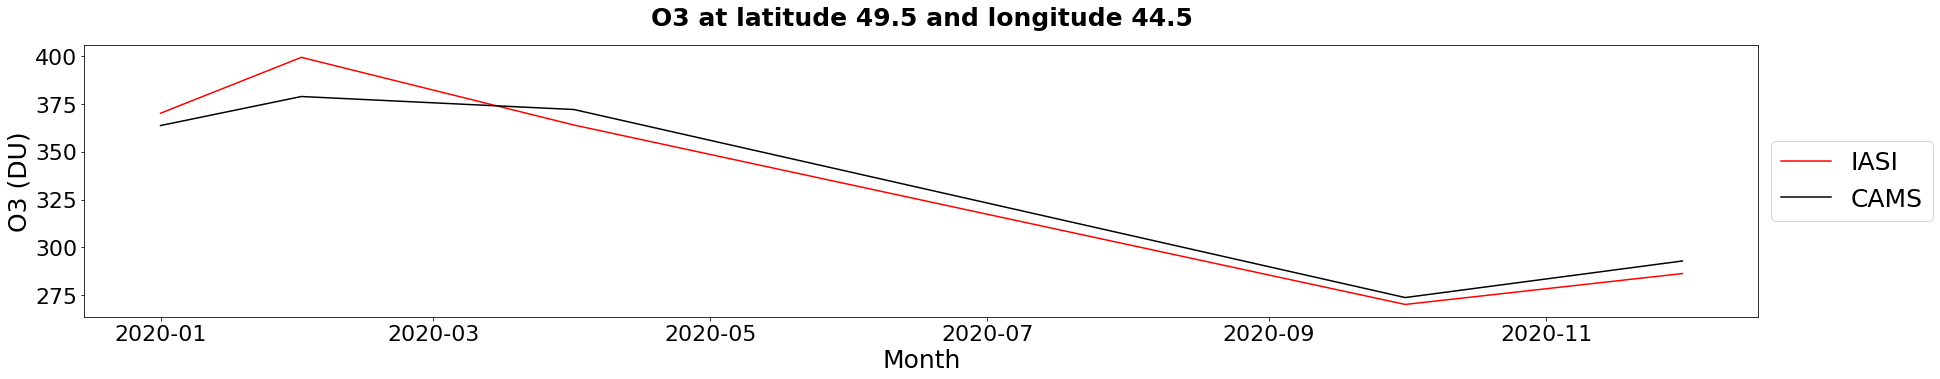

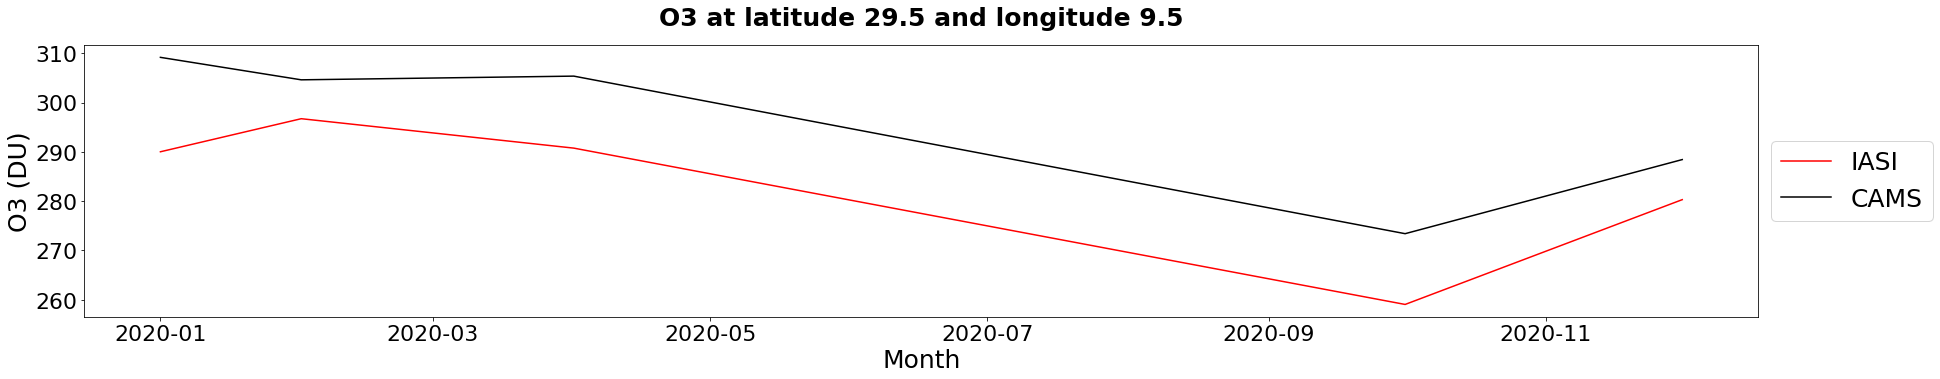

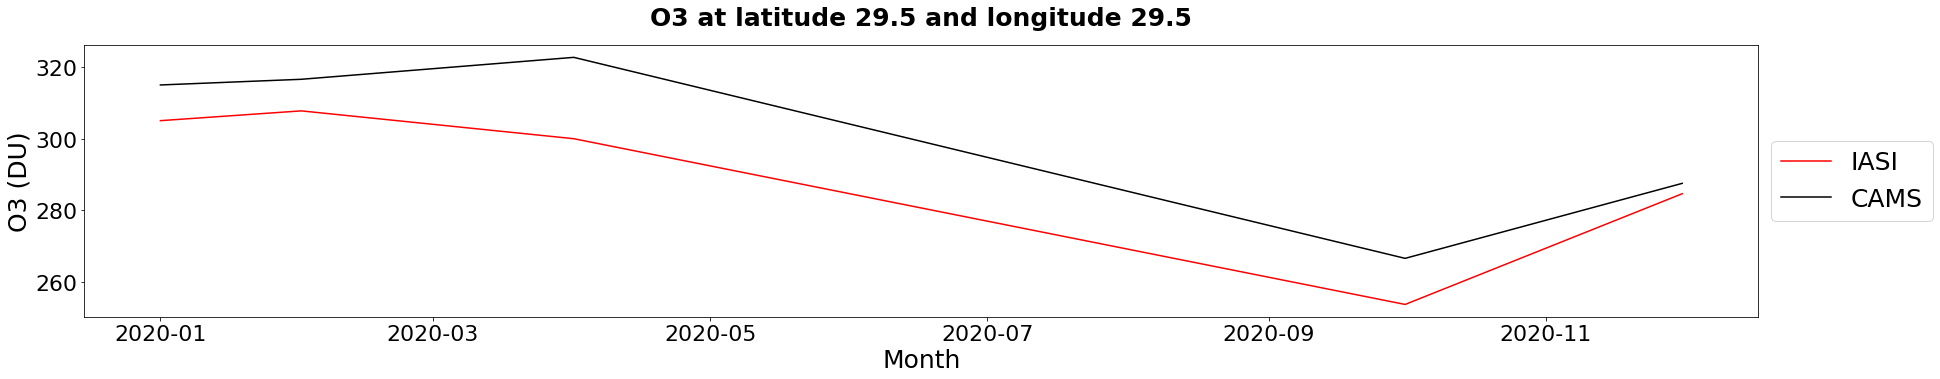

In [17]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
coords_search = pairwise(coords_search_list)
retrieval_table_all =  retrieve_coords(merge_table, coords_search, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all